#### Advanced Statistics for Data Science (Spring 2022)
# Home Assignment 6
#### Topics:
- Multiple Regression
- Model/Variable Selection

#### Due: 07/06/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: Tzach Larboni 

**Student ID**: 302673355

**Date**: 09.06.2022

$
\newcommand{\Id}{{\mathbf{I}}}  
\newcommand{\SSE}{\mathsf{SSE}}
\newcommand{\SSR}{\mathsf{SSR}}
\newcommand{\MSE}{\mathsf{MSE}}
\newcommand{\simiid}{\overset{iid}{\sim}}
\newcommand{\ex}{\mathbb E}
\newcommand{\var}{\mathrm{Var}}
\newcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\newcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\newcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\newcommand{\reals}{\mathbb R}
\newcommand{\Ncal}{\mathcal N}
\newcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\tr}{\operatorname{Tr}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\sign}{\operatorname{sign}}
$


<hr>
<hr>

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import itertools

## Problem 1 (Multiple Regression)

Use the house prices dataset from class. Load it using the function ``load_house_prices_data``. We will use ``LogSalePrice`` as the targert variable (note that this is a transformed version of the original sale prince)

1. Use all varaibles in the data reteruned by ``load_house_prices_data``. Find at least one pair of competing predictors.
2. A constuction company is trying to figure out how to design a new development for maximal profit. They propose that since ``SecondFlrSF`` (second floor square footage, proportional to second floor square meter) is correlated with ``LogSalePrice``, they should try and maximize second floor area in their designs. Does this conclusion make sense considering that ``SecondFlrSF`` is correlated with``TotRmsAbvGrd``? offer a procedure that checks the effect of ``SecondFlrSF`` on ``LogSalePrice`` and gives more information to make such decision.


In [15]:
def load_house_prices_data(path = "housing_prices.csv"):
    """
    Args:
    -----
    path:  path to csv file
    
    Load and clean house prices data:
        filters for numeric predictors only
        filters for small lots only
        renames varaibles so that all variable names begins with [a-z]
        applies a variance stabilizing transformation to SalePrice
        removes outliers
        
    """
    
    
    def detect_outliers(df, q=0.01):
        lower_outliers = df < df.quantile(q)
        upper_outliers = df > df.quantile(1-q)
        return lower_outliers | upper_outliers
    
    data_raw = pd.read_csv(path)
    data1 = data_raw[data_raw.LotArea < 15000]  # focus on small lots
    data1 = data1.select_dtypes('number').dropna()
    data1 = data1.rename( # stats model formula cannot have
        # covaraite names starting with non letter
        columns = {'1stFlrSF': 'FirstFlrSF',
                   '2ndFlrSF': 'SecondFlrSF'}) 
                                                              
    variables =[
        'SalePrice',
        'LotArea', 
        'YearBuilt',
         'YrSold', 'MoSold', 
         'Fireplaces', 
        'GarageCars', 'ScreenPorch', 
         'HalfBath', 'FullBath',
         'GrLivArea', 
         'BedroomAbvGr',
        'FirstFlrSF', 
        'SecondFlrSF',
        'TotRmsAbvGrd',
        'LowQualFinSF', 'TotalBsmtSF',
        'LotFrontage', 'WoodDeckSF',
         'OverallQual',
         'OverallCond'
    ]

    data1 = data1.filter(variables).dropna()
    data1['LogSalePrice'] = np.log(1 + data1['SalePrice'])
    data1 = data1.drop('SalePrice', axis=1)
    
    mask = detect_outliers(data1, .01).any(1)
    print(f"Masked a fraction of {mask.mean()} of the data due to outliers")
    return data1[~mask]


#### Part 1

To find pairs of competeing predictors, I'll first generate a model with all of the features, generate all couples of features and create model without each features from the pairs. In case both are significant only when the other is not included in the model, I'll stop and print the two attributes and their respective stats.

In [98]:
df = load_house_prices_data()
df.head()

Masked a fraction of 0.14971209213051823 of the data due to outliers


,LotArea,YearBuilt,YrSold,MoSold,Fireplaces,GarageCars,ScreenPorch,HalfBath,FullBath,GrLivArea,...,FirstFlrSF,SecondFlrSF,TotRmsAbvGrd,LowQualFinSF,TotalBsmtSF,LotFrontage,WoodDeckSF,OverallQual,OverallCond,LogSalePrice
0,8450,2003,2008,2,0,2,0,1,2,1710,...,856,854,8,0,856,65.0,0,7,5,12.247699
1,9600,1976,2007,5,1,2,0,0,2,1262,...,1262,0,6,0,1262,80.0,298,6,8,12.109016
2,11250,2001,2008,9,1,2,0,1,2,1786,...,920,866,6,0,920,68.0,0,7,5,12.317171
3,9550,1915,2006,2,1,3,0,0,1,1717,...,961,756,7,0,756,60.0,0,7,5,11.849405
4,14260,2000,2008,12,1,3,0,1,2,2198,...,1145,1053,9,0,1145,84.0,192,8,5,12.429220


In [104]:
ALPHA = 0.05
competing_pairs = []
tested_pairs = []

all_features = list(df.columns[:-1])
target = df.columns[-1]
full_model = smf.ols(f'{target} ~ {" + ".join(all_features)} + 1', data=df).fit()


for test_col in all_features:
    for comp_col in all_features:
        
        if test_col == comp_col:
            continue
        
        tested_pairs.append(tuple([test_col, comp_col]))
        
        if full_model.pvalues[test_col] < ALPHA:
            continue
        
        
        filtered_features = [f for f in all_features if f != comp_col]
        sub_model = smf.ols(f'{target} ~ {" + ".join(filtered_features)} + 1', data=df).fit()
        
        if sub_model.pvalues[test_col] < ALPHA:
            competing_pairs.append([test_col, comp_col])
        
            print("------------------------------")
            print(f"{test_col} and {comp_col} are competing columns.\nThe p value of {test_col} with {comp_col} is {full_model.pvalues[test_col]:.3f} and {sub_model.pvalues[test_col]:.3f} without it.")
            print("------------------------------")
            
            
print(f"Overall, there are {len(competing_pairs)}")

------------------------------
MoSold and OverallQual are competing columns.
The p value of MoSold with OverallQual is 0.162 and 0.032 without it.
------------------------------
------------------------------
FullBath and YearBuilt are competing columns.
The p value of FullBath with YearBuilt is 0.910 and 0.000 without it.
------------------------------
------------------------------
GrLivArea and FirstFlrSF are competing columns.
The p value of GrLivArea with FirstFlrSF is 0.947 and 0.000 without it.
------------------------------
------------------------------
GrLivArea and SecondFlrSF are competing columns.
The p value of GrLivArea with SecondFlrSF is 0.947 and 0.000 without it.
------------------------------
------------------------------
FirstFlrSF and GrLivArea are competing columns.
The p value of FirstFlrSF with GrLivArea is 0.213 and 0.000 without it.
------------------------------
------------------------------
SecondFlrSF and GrLivArea are competing columns.
The p value of S

#### Part 2

2. A constuction company is trying to figure out how to design a new development for maximal profit. They propose that since ``SecondFlrSF`` (second floor square footage, proportional to second floor square meter) is correlated with ``LogSalePrice``, they should try and maximize second floor area in their designs. Does this conclusion make sense considering that ``SecondFlrSF`` is correlated with``TotRmsAbvGrd``? offer a procedure that checks the effect of ``SecondFlrSF`` on ``LogSalePrice`` and gives more information to make such decision.


I'll first calculate the direct correlation between the two variables, just as a sanity check:

In [89]:
corr, p_val = st.pearsonr(df['LogSalePrice'], df['SecondFlrSF'])
print(f"The correlation between LogSalePrice and SecondFlrSF is {corr:.3f} with p value of {p_val:.3f}")

The correlation between LogSalePrice and SecondFlrSF is 0.239 with p value of 0.000


Indeed, it seems that the head on correlation between the two is positive and significant. Next, I'll calculate the partial correlation of `SecondFlrSF` and `LogSalePrice` given `TotRmsAbvGrd` to get the correlation between `SecondFlrSF` and `LogSalePrice`, adjusted to `TotRmsAbvGrd`. If the correlation is significant, then I would recommend not to optimize for `SecondFlrSF`.


In [91]:
sec_flr_sf_tot_rms_model = sm.OLS(df['LogSalePrice'], sm.add_constant(df['TotRmsAbvGrd'])).fit() 
price_tot_rms_model = sm.OLS(df['SecondFlrSF'], sm.add_constant(df['TotRmsAbvGrd'])).fit() 

corr_adj, p_val_adj = st.pearsonr(sec_flr_sf_tot_rms_model.resid, price_tot_rms_model.resid)

print(f"The partial correlation between LogSalePrice and SecondFlrSF, adjusted to TotRmsAbvGrd is {corr_adj:.3f} with p value of {p_val_adj:.3f}")

The partial correlation between LogSalePrice and SecondFlrSF, adjusted to TotRmsAbvGrd is -0.048 with p value of 0.156


It seems that the positive correlation between `LogSalePrice` and `SecondFlrSF` have become insignificant and negative when adjusting to `TotRmsAbvGrd`. If so, I wouldn't recommand to optimize for `SecondFlrSF` to the team.

## Problem 2 (Variable Selection)

Use the house prices dataset from class. Load it using the function ``load_house_prices_data``. 

1. Write the function ``backward_select`` (prototype below). Apply it on the house prices dataset and report the resulting model. 
2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out error (n-fold cross validation). What is the leave-one-out error of the model you found in 1 ?
3. Consider the predictors ``OverallCond``, ``YearBuilt``, ``LotArea``, ``Fireplaces``. Go over all $2^4$ models. Evaluate $R^2$, AIC, BIC, and leave-one-out CV-error for every model and print the results. Report on the model with lowest AIC, BIC, CV-error. 

Hint: for 1, modify the ``forward_select`` function from class.

#### Part 1

In [114]:
def backward_select(data, response, sig_level=.05):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data: pandas DataFrame with all possible predictors and response

    response: string, name of response column in data
    
    sig_level:  significance level for F-test

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept selected by backward selection
           evaluated by R-squared and F-test for extra sum of squares
    """
    remaining = [c for c in data.columns if not c == response]
    
    n = len(data)
    Ftest_pval = sig_level + 1000
    
    varst = ' + '.join(remaining)
    formula = f"{response} ~ {varst} + 1"
    fitted = smf.ols(formula, data).fit()
    SS_prev = fitted.ssr
    
    itr = 0
    while remaining and Ftest_pval > sig_level:
        itr += 1
        R2_without_candidates = []
        SS_without_candidates = {}
        for candidate in remaining:
            cur_vars = remaining.copy()
            cur_vars.remove(candidate)
            
            varst = ' + '.join(cur_vars)
            formula = f"{response} ~ {varst} + 1"
            fitted = smf.ols(formula, data).fit()
            R2 = fitted.rsquared
            SS_candidate = fitted.ssr
            R2_without_candidates.append((R2, candidate))
            SS_without_candidates[candidate] = SS_candidate

        R2_without_candidates.sort()
        best_new_R2, best_candidate = R2_without_candidates[-1]
        SS_new = SS_without_candidates[best_candidate]
        
        dof = n - len(remaining) - 1
        f = (SS_new - SS_prev) / (SS_new / dof)
        Ftest_pval = st.f.sf(f, dfn = 1, dfd = n - len(remaining) - 1)
        
        SS_prev = SS_new
        
        print(f"=========  Step {itr} ==========")
        print(f"Best Candidate = {best_candidate}")
        print(f"Best R2 = {best_new_R2}")
        print(f"Ftest = {Ftest_pval}")
        print("=============================")
        
        if Ftest_pval > sig_level:
            remaining.remove(best_candidate)
        else:
            print(f"We do not remove {best_candidate}")

    formula = f"{response} ~ {' + '.join(remaining)} + 1"
    model = smf.ols(formula, data).fit()
    
    return model

In [115]:
df = load_house_prices_data()

print("-------------------------------------------")
optimal_model = backward_select(df, "LogSalePrice")


Masked a fraction of 0.14971209213051823 of the data due to outliers
-------------------------------------------
=========  Step 1 ==========
Best Candidate = SecondFlrSF
Best R2 = 0.8813367852737968
Ftest = 1.0
=========  Step 2 ==========
Best Candidate = FirstFlrSF
Best R2 = 0.8813367839222537
Ftest = 0.997494872674697
=========  Step 3 ==========
Best Candidate = FullBath
Best R2 = 0.8813350395146318
Ftest = 0.9101404331315246
=========  Step 4 ==========
Best Candidate = YrSold
Best R2 = 0.8812921022753188
Ftest = 0.5754049013916762
=========  Step 5 ==========
Best Candidate = TotRmsAbvGrd
Best R2 = 0.881228316291594
Ftest = 0.4946941636030455
=========  Step 6 ==========
Best Candidate = LowQualFinSF
Best R2 = 0.881141609985913
Ftest = 0.4258690210838584
=========  Step 7 ==========
Best Candidate = MoSold
Best R2 = 0.8808095534727463
Ftest = 0.1196586746853972
=========  Step 8 ==========
Best Candidate = LotFrontage
Best R2 = 0.8801924897242572
Ftest = 0.03435180755204274
We d

#### Part 2
Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out error (n-fold cross validation). What is the leave-one-out error of the model you found in 1 ?

In [116]:
RANDOM_SEED = 123

In [211]:
def calc_CV_mean_squared_error(target, k, features=None):
    all_errors = []
    
    y_tot = df[target].values
    if features == None:
        X_tot = np.c_[np.ones_like(y_tot)]
    else:
        X_tot = df[features].values

    temp_data = np.column_stack((X_tot, y_tot))

    np.random.seed(RANDOM_SEED)
    np.random.shuffle(temp_data)

    X, y = temp_data[:, : -1], temp_data[:, -1]    
    X = sm.add_constant(X)

    fold_size = len(y) // k
    start_test, end_test = 0, fold_size
    for _ in range(k):
        X_train = np.concatenate( (X[: start_test], X[end_test: ] ), axis=0) 
        y_train = np.concatenate( (y[: start_test], y[end_test: ] ), axis=0) 
        
        X_test = X[start_test: end_test]
        y_test = y[start_test: end_test]

        model = sm.OLS(y_train, X_train).fit()
        
        error = y_test - model.predict(X_test)
        all_errors.append(error)
        
        start_test += fold_size
        end_test += fold_size

        if _ == k-1:  # if it's the last iteration
            end_test_fold = -1  # take all the remaining rows

    mse = np.mean(np.array(all_errors) ** 2)
    return mse

In [212]:
mse = calc_CV_mean_squared_error(target, len(df), all_features)
print(f"The CV leave-one-out error of the model found in part 1 is {mse:.3f}")

The CV leave-one-out error of the model found in part 1 is 0.014


#### Part 3
Consider the predictors ``OverallCond``, ``YearBuilt``, ``LotArea``, ``Fireplaces``. Go over all $2^4$ models. Evaluate $R^2$, AIC, BIC, and leave-one-out CV-error for every model and print the results. Report on the model with lowest AIC, BIC, CV-error. 

In [213]:
relevant_features = ['OverallCond', 'YearBuilt', 'LotArea', 'Fireplaces']
all_combs = []

for i in range(len(relevant_features) + 1):
    comb = list(itertools.combinations(relevant_features, i))
    all_combs.extend(list(comb))

all_combs = [list(i) for i in all_combs]

In [214]:
def calc_aic(n, ss_res, p):
    return n * np.log(ss_res/n) + 2 * p

def calc_bic(n, ss_res, p):
    return n * np.log(ss_res/n) + p * np.log(n)

In [215]:
r_squared = {}
aic = {}
bic = {}
cv_mse = {}


for feature_comb in all_combs:    
    model = smf.ols(f'{target} ~ {" + ".join(feature_comb)} + 1', data=df).fit()
    
    if feature_comb == []:
        feature_comb = ['const']
        model = smf.ols(f'{target} ~ 1', data=df).fit()

    model_r_squared = model.rsquared
    
    r_squared.update({str(feature_comb): model_r_squared})
    
    n, p = len(df), len(feature_comb) + 1
    
    model_aic = calc_aic(n, model.ssr, p)
    aic.update({str(feature_comb): model_aic})
    
    model_bic = calc_bic(n, model.ssr, p)
    bic.update({str(feature_comb): model_bic})
    
    if feature_comb == ['const']:
        model_cv_mse = calc_CV_mean_squared_error(target, n, features=None)
        
    else:
        model_cv_mse = calc_CV_mean_squared_error(target, n, feature_comb)
            
    cv_mse.update({str(feature_comb): model_cv_mse})
    
    print(f"For model {feature_comb}:\n     R^2 = {model_r_squared:.3f}\n     CV MSE = {model_cv_mse:.3f}\n     AIC = {model_aic:.3f}\n     BIC = {model_bic:.3f}")
    


For model ['const']:
     R^2 = 0.000
     CV MSE = 0.111
     AIC = -1945.401
     BIC = -1935.827
For model ['OverallCond']:
     R^2 = 0.035
     CV MSE = 0.107
     AIC = -1977.014
     BIC = -1967.440
For model ['YearBuilt']:
     R^2 = 0.459
     CV MSE = 0.060
     AIC = -2489.741
     BIC = -2480.168
For model ['LotArea']:
     R^2 = 0.126
     CV MSE = 0.097
     AIC = -2064.785
     BIC = -2055.211
For model ['Fireplaces']:
     R^2 = 0.180
     CV MSE = 0.091
     AIC = -2121.422
     BIC = -2111.848
For model ['OverallCond', 'YearBuilt']:
     R^2 = 0.477
     CV MSE = 0.058
     AIC = -2518.058
     BIC = -2503.698
For model ['OverallCond', 'LotArea']:
     R^2 = 0.154
     CV MSE = 0.094
     AIC = -2091.787
     BIC = -2077.427
For model ['OverallCond', 'Fireplaces']:
     R^2 = 0.205
     CV MSE = 0.089
     AIC = -2146.463
     BIC = -2132.103
For model ['YearBuilt', 'LotArea']:
     R^2 = 0.546
     CV MSE = 0.051
     AIC = -2643.152
     BIC = -2628.791
For model ['

In [224]:
lowest_aic = sorted(aic, key=aic.get)[0]
lowest_bic = sorted(bic, key=aic.get)[0]

print(f"The lowest AIC is {aic[lowest_aic]:.3f} for the model {lowest_aic}")
print(f"The lowest BIC is {bic[lowest_bic]:.3f} for the model {lowest_bic}")


The lowest AIC is -2875.815 for the model ['OverallCond', 'YearBuilt', 'LotArea', 'Fireplaces']
The lowest BIC is -2851.881 for the model ['OverallCond', 'YearBuilt', 'LotArea', 'Fireplaces']


## Problem 3 (Selecting Order of Regression using Cross-Validation)

Consider the dataset ``AnneFrank.csv``, describing the number of searches of the term "Anne Frank" by hour over several days in February 2022. The cell below contains code you should use to arrange the data by hours. 

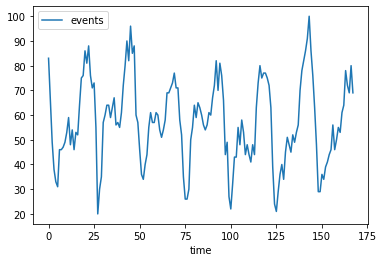

In [234]:
AnneFrank = pd.read_csv("AnneFrank.csv", header=1, names=['time', 'events'])
AnneFrank['date'] = pd.to_datetime(AnneFrank.time)
AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000
AnneFrank['time'] = AnneFrank['time'] - AnneFrank['time'].min()
AnneFrank.plot(x='time', y='events'); plt.show()

af_df = AnneFrank.copy()

In this question you will fit a model to the response based on $2p+1$ predictors of the form:
$$
\begin{align}
x_1 = [1,~\ldots~,1]
\end{align}
$$
$$
\begin{align}
x_{2k} & = \sin(2 \pi \cdot k \cdot t / 60) \\
x_{2k+1} & = \cos(2 \pi \cdot k \cdot t / 60), \qquad k=1,\ldots,p.
\end{align}
$$
(these are sinusoids of increaasing frequency at a resolution of 1min) You will then use the selected model to predict the number of events in future times. 

1. Write a function ``generate_Z`` that recieves as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.
2. For each $p=1,\ldots,20$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evalaute its leave-one-out CV error. Plot the CV error versus $p$. 
3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above. 
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value. 
5. For each $t$ in 4, construct a 0.95 prediction interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Here, you may ignore the danger of inference based on the t distribution after applying a model selection procedure. 

Hints: (2) In order to evalaute the CV error, you'll need the hat matrix (which you can get directly from Z) and the residuals in the LS fit (which you can get from the ``resid`` property of the fitted model object returned by ``statsmodels.api.OLS.fit``). (4) you can use the function ``predict`` of the fitted model object by passing new predictors that you generate using ``generate_Z``. For (5), $s^2$ is given by the property ``mse_resid`` (or ``ssr`` divided by the number of degrees of freedom). Also note that the number of degrees of freedom is $2p+1$ where $p$ is the number you found in 3. 

In [236]:
af_df.head()

,time,events,date
0,0.0,83,2022-02-14 09:00:00
1,1.0,66,2022-02-14 10:00:00
2,2.0,49,2022-02-14 11:00:00
3,3.0,38,2022-02-14 12:00:00
4,4.0,33,2022-02-14 13:00:00


#### Part 1

In [226]:
def generate_Z(t, p):
    """
    Args:
    ----
    t:   vector of time samples (length n)
    p:   number of frequencies (overal 2p+1 predictors)
    
    Returns:
    --------
    Z:  design matrix of size (n, 2p+1)
    """
        
    n = len(t)
    Z = np.ones_like(n)
    
    for k in range(1, p + 1):
        Z = np.hstack((Z,
                       np.sin(2 * np.pi * k * (t / 60)),
                       np.cos(2 * np.pi * k * (t / 60))))
    

    return Z

#### Part 2 

In [340]:
def leave_one_out_cv_means_squared_error(Z,y):
    hat_matrix = Z @ np.linalg.inv(Z.T @ Z) @ Z.T 
    
    y_hat = hat_matrix @ y
    
    beta_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ y
    
    epsilon = y - y_hat
    
    H_ii = hat_matrix.diagonal()
    
    squared_errors = (epsilon / (1 - H_ii)) ** 2
    
    mean_squared_errors = np.mean(squared_errors)
    return {"mse": mean_squared_errors,
            "y_hat": y_hat,
            "beta_hat": beta_hat,
            "epsilon": epsilon
           }

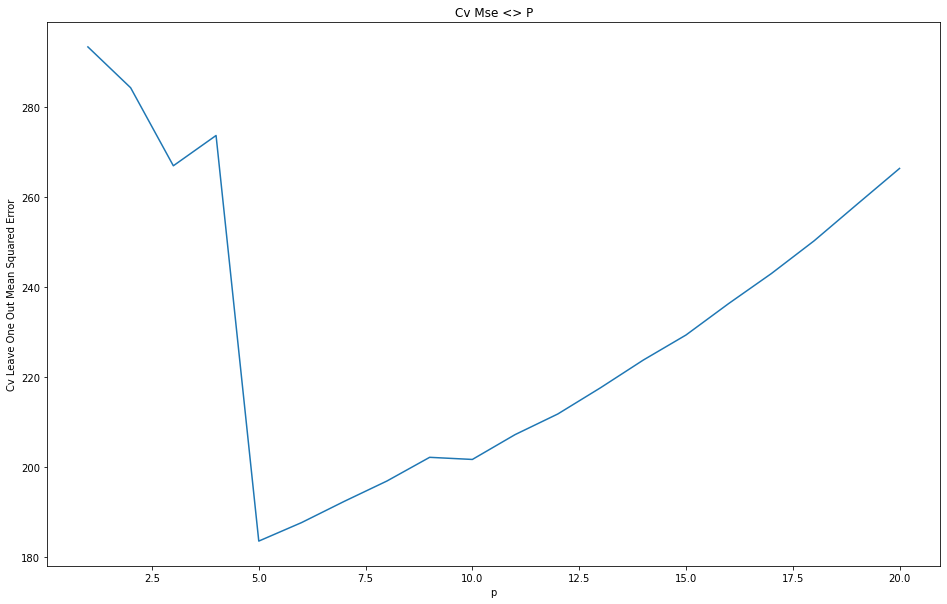

In [341]:
y = af_df['events'].values.reshape(-1, 1)
t = af_df['time'].values.reshape(-1, 1)

all_mses = []

ps_and_mses = {}

for p in range(1, 21):
    Z = generate_Z(t, p)
    cv_mse = leave_one_out_cv_means_squared_error(Z, y)["mse"]
    all_mses.append(cv_mse)

    ps_and_mses.update({str(p): cv_mse})

plt.figure(figsize=(16, 10))
plt.plot(range(1, 21), all_mses)
plt.xlabel("p")
plt.ylabel("CV leave one out mean squared error".title())
plt.title("cv MSE <> p".title())
plt.show()


#### Part 3

In [342]:
min_mse_p = sorted(ps_and_mses, key=ps_and_mses.get)[0]
print(f"The minimum p is {min_mse_p}, for which the CV MSE is {ps_and_mses[min_mse_p]:.3f}")
min_mse_p = int(min_mse_p)

The minimum p is 5, for which the CV MSE is 183.630


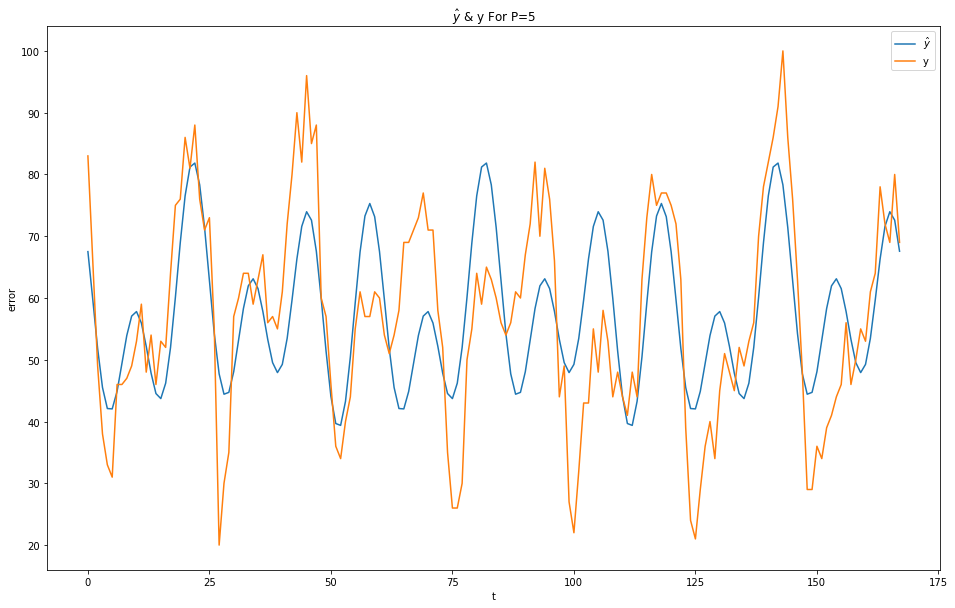

In [343]:
min_mse_Z = generate_Z(t, min_mse_p)
min_mse = leave_one_out_cv_means_squared_error(min_mse_Z, y)

min_mse_y_hat = min_mse["y_hat"]

plt.figure(figsize=(16, 10))
plt.plot(t, min_mse_y_hat, label = "$\hat{y}$")
plt.plot(t, y, label = "y")
plt.legend()
plt.xlabel("t")
plt.ylabel("error")
plt.title("$\hat{y}$ & y For P=5")
plt.show()

#### Part 4
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value. 


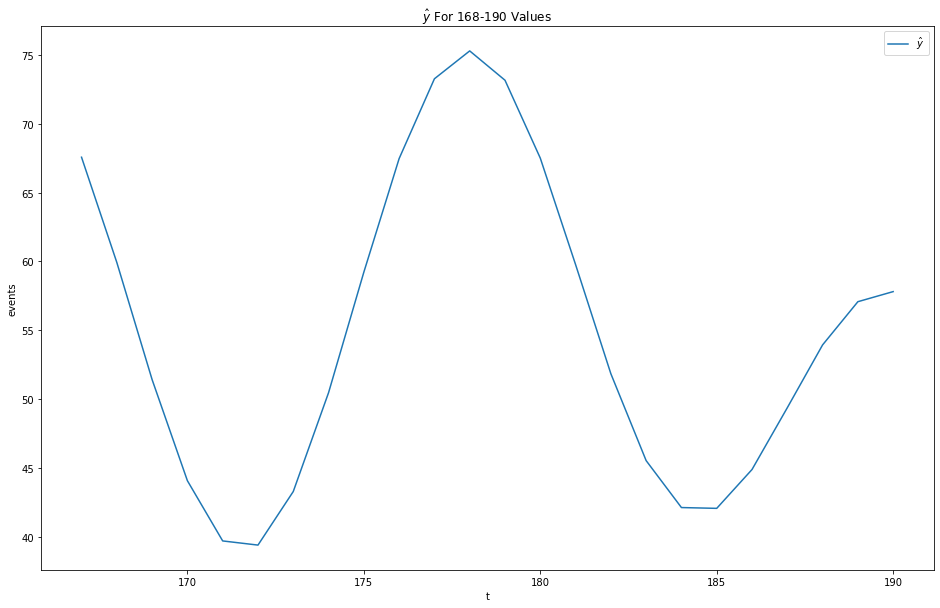

In [344]:
future_ts = np.arange(167, 191).reshape(-1,1)
future_Z = generate_Z(future_ts, min_mse_p)
y_pred = future_Z @ min_mse["beta_hat"]

plt.figure(figsize=(16, 10))
plt.plot(future_ts, y_pred, label="$\hat{y}$")
plt.xlabel("t")
plt.ylabel("events")
plt.title("$\hat{y}$ For 168-190 Values")
plt.legend()
plt.show()


#### Part 5
5. For each $t$ in 4, construct a 0.95 prediction interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Here, you may ignore the danger of inference based on the t distribution after applying a model selection procedure.

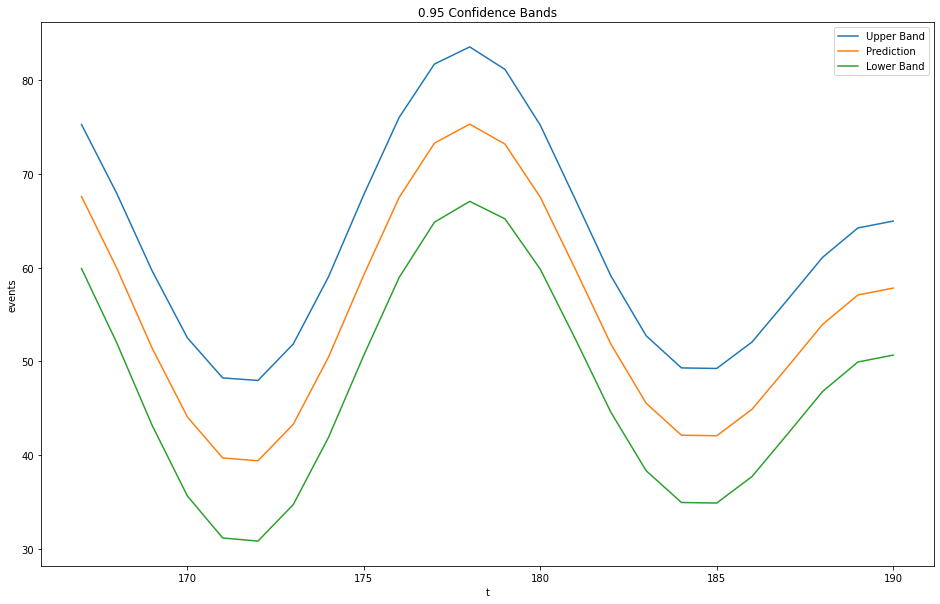

In [352]:
ALPHA = 0.05
n = len(y)
DoF = 2 * min_mse_p + 1
t = st.t.ppf(1 - ALPHA / 2, DoF)

epsilon = min_mse["epsilon"]

s_squared = (epsilon.T @ epsilon) / (n - DoF)
s = np.sqrt(s_squared).flatten()[0]

upper_bands, lower_bands = [],[]

for index, row in enumerate(future_Z):
    row_vector = row.reshape(-1, 1)
    b_squared = row_vector.T @ np.linalg.inv(min_mse_Z.T @ min_mse_Z) @ row 
    b = np.sqrt(b_squared).flatten()

    band = t * s * b
    upper_band, lower_band = y_pred[index] + band, y_pred[index] - band

    upper_bands.append(upper_band)
    lower_bands.append(lower_band)
    
plt.figure(figsize=(16, 10))
plt.plot(future_ts, upper_bands, label="Upper Band")
plt.plot(future_ts, y_pred, label="Prediction")
plt.plot(future_ts, lower_bands, label="Lower Band")
plt.legend()
plt.xlabel("t")
plt.ylabel("events")
plt.title("0.95 Confidence Bands")
plt.show()

In [ ]:


upper_band = np.asarray(upper_band)
lower_band = np.asarray(lower_band)

# plot
plt.figure(figsize=(16, 10))
plt.plot(t_future, upper_bands, label="upper band".title(), color="g")
plt.plot(t_future, y_hat_future, "-o", label="Response", color="b")
plt.plot(t_future, lower_bands, label="lower band".title(), color="orange")
plt.title("Predicted reponse and lower & upper Confidence Bands".title())
plt.legend()
plt.xlabel("Time")
plt.ylabel("Response value")
plt.show()
